# Avast-CTU Public CAPE Dataset (Model Example)

The following document demonstrates usage of the dataset. We first show statistics of the dataset, following by creating an HMIL model build and trained based no the reduced reports.

The example is using Julia 1.6, Mill.jl 2.7 and JsonGrinder 2.2.3. For details about julia or the main packages, please see the official documentations:
* https://julialang.org
* https://ctuavastlab.github.io/JsonGrinder.jl/stable/

Activation of the environment, addiing the packages.

In [27]:
using Pkg
Pkg.activate("./")

using Flux, MLDataPattern, Mill, JsonGrinder, JSON, Statistics, IterTools, StatsBase, ThreadTools
using JsonGrinder: suggestextractor, ExtractDict
using Mill: reflectinmodel
using CSV, DataFrames
using Random
using Dates
using Plots
using Printf


  Activating environment at `~/PubliCAPE/Project.toml`


Some parts of the code is parallelized to speed up loading / working with data. The following variable determines the number of threads.

In [19]:
THREADS = Threads.nthreads() ;

Setting the path variables to directories containing metadata (labels) and reports: 

In [8]:
PATH_TO_REPORTS = "PATH/TO/REPORTS/"
PATH_TO_REDUCED_REPORTS = PATH_TO_REPORTS * "public_small_reports/"
PATH_TO_FULL_REPORTS = PATH_TO_REPORTS * "public_full_reports/"
PATH_TO_LABELS = "./" ;

Loading the labels:

In [4]:
df_labels = CSV.read(PATH_TO_LABELS * "public_labels.csv", DataFrame) ;

## Statistics for malware families in the dataset:

We first provide some basic statistics. First, we show the list of malware families in the dataset and how many samples belong to each family. 

In [10]:
all_samples_count = size(df_labels, 1)
println("All samples: $(all_samples_count)")
println("Malware families: ")
[println(k => v) for (k,v) in countmap(df_labels.classification_family)] ;

All samples: 48976
Malware families: 
"Zeus" => 2594
"Ursnif" => 1343
"HarHar" => 655
"Trickbot" => 4202
"Lokibot" => 4191
"njRAT" => 3372
"Adload" => 704
"Qakbot" => 4895
"Emotet" => 14429
"Swisyn" => 12591


We now show how the sampels are distributed over time:

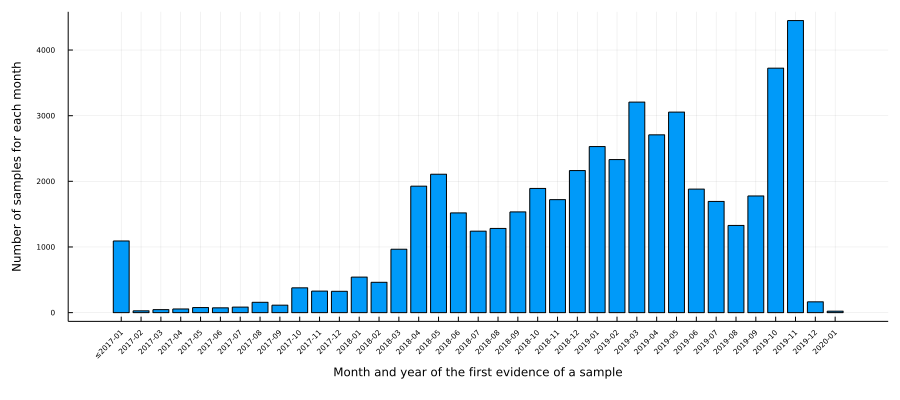

In [7]:
df_labels[!,:month] = map(i -> string(year(i), "-", month(i) < 10 ? "0$(month(i))" : month(i)), df_labels.date) ;
month_counts = sort(countmap(df_labels.month) |> collect, by = x -> x[1])
index2017 = findfirst(j -> j[1] == "2017-01", month_counts)
previous_months = sum(map(j -> j[2], month_counts[1:index2017-1]))
month_counts[index2017] = Pair("≤"*month_counts[index2017][1], month_counts[index2017][2]+previous_months)
deleteat!(month_counts, 1:64)
bar(getindex.(month_counts,2), xticks=(1:length(month_counts), getindex.(month_counts,1)), xtickfontsize=5, ytickfontsize=5, xrotation=45, yguidefontsize=8, xguidefontsize=8, legend=false,
    xlabel="Month and year of the first evidence of a sample", ylabel="Number of samples for each month",size=(900,400),
    left_margin = 5Plots.mm, bottom_margin = 10Plots.mm)

## Building a model

We first need to split data into the training and testing part. We do this according the time to reflect the way in which the models should be used (i.e., to detect new, unseen malware). We are using date **2019-08-01** as an example splitting date, however, other dates can be used in a more detailed study of the drift and changes in the data distributions. 

In [11]:
timesplit = Date(2019,8,1)
train_indexes = findall(i -> df_labels.date[i] < timesplit, 1:all_samples_count)
test_indexes = [setdiff(Set(1:all_samples_count), Set(train_indexes))...] ;

train_size = length(train_indexes)
test_size = length(test_indexes)

println("Train size: $(train_size)")
println("Test size: $(test_size)")

Train size: 37512
Test size: 11464


Now we need to load all JSON files. For the example model, we are using reduced reports:

In [12]:
jsons = tmap(df_labels.sha256) do s
    try 
        open(JSON.parse, "$(PATH_TO_REDUCED_REPORTS)$(s).json")
    catch e
        @error "Error when processing sha $s: $e"
    end
end ;
@assert size(jsons, 1) == all_samples_count # verifying that all samples loaded correctly

Next, we are going to build schema out of the JSONs and model corresponding to these JSONs. Note that we are using only training data to build the schema and the model.

In [17]:
chunks = Iterators.partition(train_indexes, div(train_size, THREADS))
sch_parts = tmap(chunks) do ch
    JsonGrinder.schema(jsons[ch])
end
time_split_complete_schema = merge(sch_parts...)
printtree(time_split_complete_schema)

[Dict] 	# updated = 37512
  ├──── static: [Dict] 	# updated = 36074
  │               └── pe: [Dict] 	# updated = 36068
  │                         ├─── reported_checksum: [Scalar - String], 9338 unique values 	# updated = 36068
  │                         ├───────── versioninfo: [Empty List] 	# updated = 36068
  │                         │                         └── Nothing
  │                         ├───────────── exports: [List] 	# updated = 36068
  │                         │                         └── [Dict] 	# updated = 9623
  │                         │                               ├── address: [Scalar - String], 1696 unique values 	# updated = 9623
  │                         │                               ├── ordinal: [Scalar - Int64], 1073 unique values 	# updated = 9623
  │                         │                               └───── name: [Scalar - String], 330 unique values 	# updated = 9623
  │                         ├── imported_dll_count: [Scalar - Int64], 32 un

  │                         │                               ├────────────────────── subject_localityName: [Scalar - String], 79 unique values 	# updated = 2649
  │                         │                               ├──────────────────────── subject_commonName: [Scalar - String], 432 unique values 	# updated = 6192
  │                         │                               ├──────────────────────── subject_postalCode: [Scalar - String], 63 unique values 	# updated = 530
  │                         │                               ├────────────────────── subject_emailAddress: [Scalar - String], 3 unique values 	# updated = 4
  │                         │                               ├──────────── subject_organizationalUnitName: [Scalar - String], 32 unique values 	# updated = 809
  │                         │                               ├────────────────── subject_organizationName: [Scalar - String], 126 unique values 	# updated = 4024
  │                         │               

  │                                                                              └───── name: [Scalar - String], 8859 unique values 	# updated = 4427947
  └── behavior: [Dict] 	# updated = 37512
                  └── summary: [Dict] 	# updated = 37512
                                 ├─────── delete_files: [List] 	# updated = 37512
                                 │                        └── [Scalar - String], 10000 unique values 	# updated = 117359
                                 ├──────── delete_keys: [List] 	# updated = 37512
                                 │                        └── [Scalar - String], 493 unique values 	# updated = 5036
                                 ├─────────────── keys: [List] 	# updated = 37512
                                 │                        └── [Scalar - String], 10000 unique values 	# updated = 14590971
                                 ├──────────── mutexes: [List] 	# updated = 37512
                                 │                        └

Now we prepare the JSONs based on the scheme so that we can build and train the model. This can take a few minutes.

In [ ]:
extractor = suggestextractor(time_split_complete_schema)
data = tmap(extractor, jsons) ;

Now we are ready for creating the model, prepare minibatches and callback functions for the training.

In [21]:
labelnames = sort(unique(df_labels.classification_family))
neurons = 32
model = reflectinmodel(time_split_complete_schema, extractor,
	k -> Dense(k, neurons, relu),
	d -> SegmentedMeanMax(d),
	fsm = Dict("" => k -> Dense(k, length(labelnames))),
)

minibatchsize = 500
function minibatch()
	idx = sample(train_indexes, minibatchsize, replace = false)
	reduce(catobs, data[idx]), Flux.onehotbatch(df_labels.classification_family[idx], labelnames)
end

iterations = 200

function accuracy(x,y) 
    vals = tmap(x) do s
        Flux.onecold(softmax(model(s)), labelnames)[1]
    end
    mean(vals .== y)
end     
    

eval_trainset = shuffle(train_indexes)[1:1000]
eval_testset = shuffle(test_indexes)[1:1000]

cb = () -> begin
	train_acc = accuracy(data[eval_trainset], df_labels.classification_family[eval_trainset])
	test_acc = accuracy(data[eval_testset], df_labels.classification_family[eval_testset])
	println("accuracy: train = $train_acc, test = $test_acc")
end
ps = Flux.params(model)
loss = (x,y) -> Flux.logitcrossentropy(model(x), y)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

We can now train the model (this can take some time). Note that actual performance may slightly vary from the numbers presented in accompanying paper.

In [22]:
Flux.Optimise.train!(loss, ps, repeatedly(minibatch, iterations), opt, cb = Flux.throttle(cb, 2))

accuracy: train = 0.555, test = 0.582
accuracy: train = 0.607, test = 0.699
accuracy: train = 0.649, test = 0.71
accuracy: train = 0.7, test = 0.721
accuracy: train = 0.753, test = 0.732
accuracy: train = 0.815, test = 0.772
accuracy: train = 0.863, test = 0.828
accuracy: train = 0.887, test = 0.848
accuracy: train = 0.937, test = 0.866
accuracy: train = 0.961, test = 0.878
accuracy: train = 0.97, test = 0.881
accuracy: train = 0.975, test = 0.88
accuracy: train = 0.98, test = 0.886
accuracy: train = 0.982, test = 0.888
accuracy: train = 0.982, test = 0.887
accuracy: train = 0.981, test = 0.892
accuracy: train = 0.986, test = 0.903
accuracy: train = 0.988, test = 0.904
accuracy: train = 0.988, test = 0.904
accuracy: train = 0.987, test = 0.904
accuracy: train = 0.987, test = 0.904
accuracy: train = 0.988, test = 0.909
accuracy: train = 0.988, test = 0.913
accuracy: train = 0.988, test = 0.913
accuracy: train = 0.988, test = 0.912
accuracy: train = 0.99, test = 0.918
accuracy: train = 0

The model is trained, we can evaluate the performance on the complete test set:

In [23]:
full_test_accuracy = accuracy(data[test_indexes], df_labels.classification_family[test_indexes])
println("Final evaluation:")
println("Accuratcy on test data: $(full_test_accuracy)")

Final evaluation:
Accuratcy on test data: 0.9436496859734822


We can look at the confusion matrix table of the testing data for different malware families. The true lables are in the row, the predictions are in the column.

In [29]:
test_predictions = Dict()
for true_label in labelnames
    current_predictions = Dict()
    [current_predictions[pl]=0.0 for pl in labelnames]
    family_indexes = filter(i -> df_labels.classification_family[i] == true_label, test_indexes)
    predictions = tmap(data[family_indexes]) do s
        Flux.onecold(softmax(model(s)), labelnames)[1]
    end
    [current_predictions[pl] += 1.0 for pl in predictions]
    [current_predictions[pl] = current_predictions[pl] ./ length(predictions) for pl in labelnames]
    test_predictions[true_label] = current_predictions
end

@printf "%8s\t" "TL\\PL"
[@printf " %8s" s for s in labelnames]
print("\n")
for tl in labelnames
    @printf "%8s\t" tl 
    for pl in labelnames
        @printf "%9s" @sprintf "%.2f" test_predictions[tl][pl]*100
    end
    print("\n")
end

   TL\PL	   Adload   Emotet   HarHar  Lokibot   Qakbot   Swisyn Trickbot   Ursnif     Zeus    njRAT
  Adload	   100.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00
  Emotet	     0.00    86.40     0.00     2.01     0.00     0.06     6.23     0.65     4.65     0.00
  HarHar	     0.00     0.00    98.55     0.00     0.00     0.00     0.00     0.00     0.00     1.45
 Lokibot	     0.00     0.00     0.00    96.64     0.00     0.00     0.15     0.00     0.15     3.07
  Qakbot	     0.00     0.00     0.00     0.00    99.49     0.00     0.00     0.00     0.51     0.00
  Swisyn	     0.00     0.00     0.00     0.02     0.00    99.91     0.02     0.00     0.00     0.05
Trickbot	     0.00     0.15     0.00     0.22     0.15     0.00    98.58     0.22     0.45     0.22
  Ursnif	     1.00     0.00     1.39     4.18     0.40     0.00     2.39    81.08     9.36     0.20
    Zeus	     0.00     2.78     0.00     0.69     1.39     0.00     0.00     0.00    93.06     2.08


If you want to test the static version of the reduced model, the schema can be altered to remove the behavioral part. Re-extracting the data with the new extractor and re-training the model would work in the same way as above.

In [ ]:
time_split_static_schema = deepcopy(time_split_complete_schema)
delete!(time_split_static_schema.childs,:behavior)